## Notebook Description

This notebook is an exploration of the next steps proposed in my Readme.  There are minimal descriptions of code.

### Next steps

- Drop outliers and rerun models
- If scores don't improve find more data and engineer more features than were made previously
- Run models again and find which models are best

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import requests
import json
import warnings
import pickle
import random
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from io import BytesIO
from datetime import datetime
from igdb.wrapper import IGDBWrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
sglobal = pd.read_csv('../Data/vgsalesGlobale2.csv')
sglobal.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
sglobal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16598 non-null int64
Name            16598 non-null object
Platform        16598 non-null object
Year            16327 non-null float64
Genre           16598 non-null object
Publisher       16540 non-null object
NA_Sales        16598 non-null float64
EU_Sales        16598 non-null float64
JP_Sales        16598 non-null float64
Other_Sales     16598 non-null float64
Global_Sales    16598 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


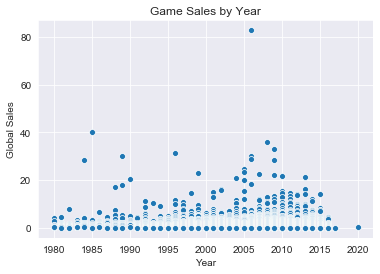

In [4]:
sns.set_style('darkgrid')
sns.scatterplot(sglobal.Year, sglobal.Global_Sales);
plt.title('Game Sales by Year')
plt.ylabel('Global Sales')
plt.show()

#### Dropping columns

In [5]:
# Name column will be dropped later
sglobal.drop(columns=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Rank'], axis=1, inplace=True)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37


#### Dropping NaN values

In [6]:
sglobal.dropna(inplace=True)
sglobal.isna().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
Global_Sales    0
dtype: int64

#### Creating another feature

In [7]:
remake = np.array(sglobal['Name'].duplicated())
remake_df = pd.DataFrame(remake, columns=['Remake'], index=sglobal.index)
remake_df.head()

,Remake
0,False
1,False
2,False
3,False
4,False


In [8]:
sglobal_nn = pd.concat((sglobal,remake_df), axis=1)
sglobal_nn.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,False
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,False
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,False
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,False


In [9]:
sglobal_nn['Remake'] = sglobal_nn['Remake'].astype(int)
sglobal_nn.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,0
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,0


In [10]:
sglobal_nn = sglobal_nn.drop('Name', axis='columns')
sglobal_nn.head()

,Platform,Year,Genre,Publisher,Global_Sales,Remake
0,Wii,2006.0,Sports,Nintendo,82.74,0
1,NES,1985.0,Platform,Nintendo,40.24,0
2,Wii,2008.0,Racing,Nintendo,35.82,0
3,Wii,2009.0,Sports,Nintendo,33.00,0
4,GB,1996.0,Role-Playing,Nintendo,31.37,0


#### Removing Wii Sports

In [11]:
sglobal_nn.drop(index = [1], axis=0, inplace=True) #This value throws off the mean by a large margin.

#### Removing Outliers

In [12]:
sglobal_nn.Global_Sales.describe()

count    16290.000000
mean         0.538473
std          1.536216
min          0.010000
25%          0.060000
50%          0.170000
75%          0.480000
max         82.740000
Name: Global_Sales, dtype: float64

In [13]:
mean = sglobal_nn.Global_Sales.mean()
stddev = sglobal_nn.Global_Sales.std()
cutoff = stddev*3
lowerrange = mean - cutoff
upperrange = mean + cutoff

In [14]:
sglobal_nooutliers = sglobal_nn[(sglobal_nn['Global_Sales'] > lowerrange) & (sglobal_nn['Global_Sales'] < upperrange)]
sglobal_nooutliers.head()

,Platform,Year,Genre,Publisher,Global_Sales,Remake
189,DS,2008.0,Sports,Sega,5.14,1
190,PS2,2003.0,Shooter,Electronic Arts,5.13,0
191,GB,1992.0,Platform,Nintendo,5.13,0
192,X360,2010.0,Role-Playing,Microsoft Game Studios,5.13,0
193,XOne,2014.0,Shooter,Activision,5.13,1


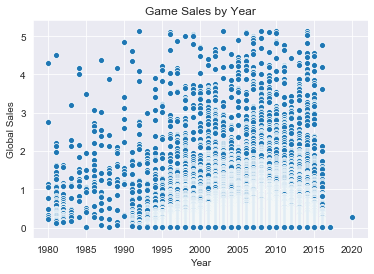

In [15]:
sns.set_style('darkgrid')
sns.scatterplot(sglobal_nooutliers.Year, sglobal_nooutliers.Global_Sales)
plt.title('Game Sales by Year')
plt.ylabel('Global Sales')
plt.show();

## Coding the first model series

In [21]:
y = sglobal_nooutliers['Global_Sales']
X = sglobal_nooutliers.drop('Global_Sales', axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [23]:
# OneHotEncoding X_train and X_test columns

ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train[['Platform', 'Genre', 'Publisher']])

ohe_cats = pd.DataFrame(ohe.transform(X_train[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_train.index)

ohe_cats_test= pd.DataFrame(ohe.transform(X_test[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_test.index)


In [24]:
# Dropping the unnecessary columns
X_train.drop(columns=['Platform', 'Genre', 'Publisher'], axis=1, inplace=True)
X_test.drop(columns=['Platform', 'Genre', 'Publisher'], axis=1, inplace=True)

In [25]:
# Concatenating the one hotted columns
X_train_ohe = pd.concat((X_train, ohe_cats), axis=1)
X_test_ohe = pd.concat((X_test, ohe_cats_test), axis=1)

In [26]:
X_train_ohe.head()

,Year,Remake,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,...,x2_Zoo Digital Publishing,x2_Zoo Games,x2_Zushi Games,x2_bitComposer Games,x2_dramatic create,x2_fonfun,x2_iWin,x2_imageepoch Inc.,x2_inXile Entertainment,x2_responDESIGN
7655,1996.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10412,2010.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8444,2016.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7549,2009.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12124,2011.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
X_test_ohe.head()

,Year,Remake,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,...,x2_Zoo Digital Publishing,x2_Zoo Games,x2_Zushi Games,x2_bitComposer Games,x2_dramatic create,x2_fonfun,x2_iWin,x2_imageepoch Inc.,x2_inXile Entertainment,x2_responDESIGN
2956,1993.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15943,2013.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8657,2016.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9044,2004.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8373,2000.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
ss = StandardScaler()

X_train_ohe_ss = ss.fit_transform(X_train_ohe)
X_test_ohe_ss = ss.transform(X_test_ohe)

### Linear Regression

In [29]:
random.seed(a=42)
linreg = LinearRegression()

linreg.fit(X_train_ohe_ss, y_train)

print(linreg.score(X_train_ohe_ss, y_train))
print(mean_absolute_error(y_train, linreg.predict(X_train_ohe_ss)))

0.23463689590590198
0.3481847030750696


In [30]:
cross_val_score(linreg, X_train_ohe_ss, y_train, cv=3)

array([-1.54432870e+28, -1.53140117e+28, -3.13826094e+28])

In [31]:
print(linreg.score(X_test_ohe_ss, y_test))
print(mean_absolute_error(y_test, linreg.predict(X_test_ohe_ss)))

-1.0222744676709043e+20
855444138.694134


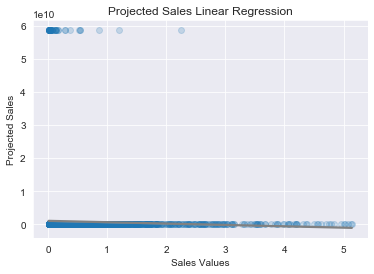

In [32]:
sns.regplot(y_test, linreg.predict(X_test_ohe_ss), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.title('Projected Sales Linear Regression')
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales');

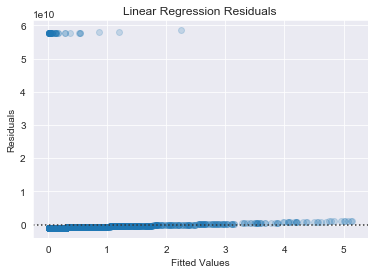

In [33]:
sns.residplot(y_test, linreg.predict(X_test_ohe_ss), scatter_kws={'alpha': 0.2})
plt.title('Linear Regression Residuals')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals');

### Ridge Regression

In [34]:
ridge = Ridge(alpha=4, random_state=42)

ridge.fit(X_train_ohe_ss, y_train)
print(ridge.score(X_train_ohe_ss, y_train))
print(mean_absolute_error(y_train, ridge.predict(X_train_ohe_ss)))

0.2346453981291231
0.3480765591623644


In [35]:
cross_val_score(ridge, X_train_ohe_ss, y_train, cv = 3).mean()

0.20095938948653555

In [36]:
print(ridge.score(X_test_ohe_ss, y_test))
print(mean_absolute_error(y_test, ridge.predict(X_test_ohe_ss)))

0.19420042648281133
0.3625678564767762


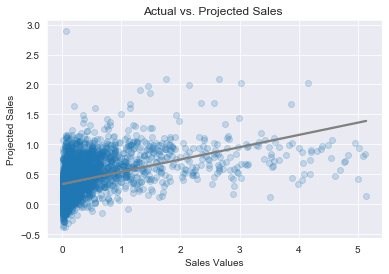

In [37]:
sns.regplot(y_test, ridge.predict(X_test_ohe_ss), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.title('Actual vs. Projected Sales ')
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales');

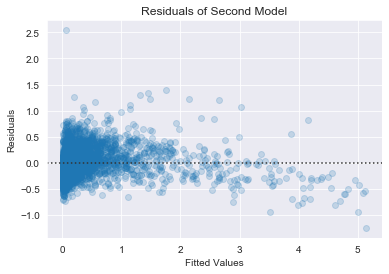

In [38]:
sns.residplot(y_test, ridge.predict(X_test_ohe_ss), scatter_kws={'alpha': 0.2})
plt.title('Residuals of Second Model')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals');

### Lasso Regression

In [39]:
lasso = Lasso(alpha= .0001)

lasso.fit(X_train_ohe_ss, y_train) 
print(lasso.score(X_train_ohe_ss, y_train))
print(mean_absolute_error(y_train, lasso.predict(X_train_ohe_ss)))

0.23463017254484442
0.34801868838834243


## Data Collection

In [ ]:
!pip install igdb-api-v4 #Installs the wrapper

To collect data from [IGDB](pi-docs.igdb.com/#about) create a twitch account.  If the instructions are follwed at the account creation site for Twitch.tv there shouldn't be a major problem.  When filling in the application the OAuth url was set as "http://localhost" to let the system know the data will be run locally then choose analytics tool from the category menu.  Once the application is accepted  a client ID is assigned to you and you can ask for a client secret.  Though this secret is used in the code to collect the data it should not be made public. As such once the code has been run it should be written down or saved to the computer and then deleted from the code.  Once the client ID and client secret have been collected an access token will be needed to collect the data from IGDB.  The request URL is found under the authentification section of the instructions and the client ID and client secret can be filled in to make a successful request.  A wrapper was created to deliver the data in a format comptible with python under wrappers, however, the readme file that shows how to run the data contains an issue that throws an error.  The solution can be found in a discussion entitled 'Main Readme Example Does Not Work' under the issues tab.  

In [ ]:
# Don't upload your client secret
client_ID = 'ryht2y9jvswue4yv5ddm894h7qvxdn'
client_secret = # Removed for security reasons!

r = requests.post(f"https://id.twitch.tv/oauth2/token?client_id={client_ID}&client_secret={client_secret}&grant_type=client_credentials")
access_token = json.loads(r._content)['access_token']
wrapper = IGDBWrapper(client_ID, access_token)

In [ ]:
# converts the information collected with the wrapper into JSON format
def bytes_to_json(byte_array):
    _  = BytesIO(byte_array)
    return json.loads(_.read())

The data collected was for the games in the sglobal dataset so the names of the games were used to identify which game data should be returned.  This did not mean that the website would have data on all the games requested so a try/except was set up to allow the request to return None if there was no data so that the request would not throw an error if there were a NaN value.  The final issue to consider when working with this API is that the rate limit for requests is four per second.  For this reason, a counter was set up to space out the information returned which told the machine to wait if it thought the rate would exceed the limit.

In [ ]:
# now = datetime.now
# window_open=now()
# count=0
# data=[]
# with tqdm(total=len(sglobal)) as pbar:
#     for name in sglobal.Name:
#         try:
#             byte_array = wrapper.api_request(
#                     'games',
#                     f'fields *; where name = "{name}";'
#             )
#             game_info = bytes_to_json(byte_array)
#             if not game_info:
#                 game_info=[None]
#         except:
#             game_info=[None]

#         data.append(game_info[0])
#         # the rate monitor
#         count+=1
#         if count % 4 == 0:
#             window_close=now()
#             difference= window_close-window_open
#             if difference.total_seconds() <= 1:
#                 sleep(1)
#             window_open=now()
#         pbar.update(1)

#### Pickling 

In [ ]:
# # Running this cell saves an instance of the collected data
# filename = 'Igdb_data'
# outfile = open(filename, 'wb')

# pickle.dump(data, outfile)
# outfile.close()

In [40]:
# Running this cell will import the collected data if there is a problem
infile = open('Igdb_data','rb')
new_data = pickle.load(infile)
infile.close()

## Creating new features

In [41]:
valid_data = [] 
for val in new_data: 
    if val != None : 
        valid_data.append(val)

In [42]:
pd.set_option('display.max_columns', None)
new_cols = pd.DataFrame(valid_data)
new_cols.drop_duplicates(subset='id', inplace=True)
new_cols['id'].value_counts()

67583     1
78349     1
122249    1
1418      1
11663     1
         ..
2764      1
717       1
4815      1
69164     1
20482     1
Name: id, Length: 7716, dtype: int64

In [43]:
new_cols.head()

,id,age_ratings,aggregated_rating,aggregated_rating_count,alternative_names,bundles,category,collection,cover,created_at,external_games,first_release_date,follows,game_modes,genres,involved_companies,keywords,name,platforms,player_perspectives,rating,rating_count,release_dates,screenshots,similar_games,slug,summary,tags,themes,total_rating,total_rating_count,updated_at,url,videos,websites,checksum,franchise,franchises,storyline,multiplayer_modes,artworks,game_engines,standalone_expansions,hypes,dlcs,expansions,status,version_parent,version_title,parent_game
0,2181,"[189, 26427]",75.00,3.0,[32754],"[130310, 136311]",0,681.0,86110.0,1372204800,"[35583, 144876, 221465, 245925, 1928625, 19289...",1.163894e+09,34.0,"[1, 2, 4]","[13, 14]","[4658, 22251]","[20, 30, 56, 274, 299, 311, 632, 977, 992, 116...",Wii Sports,[5],"[1, 2]",75.232386,188.0,"[27256, 27257, 27258, 27259]","[10247, 10248, 10249, 10250, 10251, 178474, 17...","[1244, 1352, 2182, 2185, 2186, 2194, 3915, 488...",wii-sports,Bowl like a pro or go for that home run...\nEx...,"[40, 268435469, 268435470, 536870932, 53687094...",[40],75.116193,191.0,1605484800,https://www.igdb.com/games/wii-sports,[1276],"[570, 125920]",7dd08287-257b-4b94-589c-ee707af7c003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,358,"[24, 24927]",NaN,NaN,"[31808, 31809, 31810, 31811, 31812, 31813, 31814]","[5199, 9250, 69638, 77227, 77785]",0,6118.0,97418.0,1300320000,"[30094, 142871, 190087, 220718, 1611061]",4.954176e+08,363.0,"[1, 2]","[8, 31]","[97362, 97363]","[16, 137, 226, 296, 394, 432, 558, 594, 846, 1...",Super Mario Bros.,"[5, 18, 24, 37, 41, 51, 130, 307]",[4],83.849890,802.0,"[143761, 143763, 143764, 143765, 143766, 14376...","[379065, 379066, 379067, 379068, 379069]","[1067, 1068, 1075, 1078, 1079, 2180, 3340, 334...",super-mario-bros,A side scrolling 2D platformer and first entry...,"[1, 268435464, 268435487, 536870928, 536871049...",[1],83.849890,802.0,1606003200,https://www.igdb.com/games/super-mario-bros,"[35300, 35301]","[4549, 4550]",58df069e-1ee1-a548-2f21-673729e6239d,24.0,"[24, 845]","One day, the Mushroom Kingdom was invaded by t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2183,"[192, 13218]",71.25,5.0,"[34468, 34469, 34470, 34471, 34472, 44750]",NaN,0,449.0,94766.0,1372204800,"[35546, 138281, 189061, 218733, 245265, 192841...",1.207786e+09,93.0,"[1, 2, 4]",[10],"[4656, 98978]","[25, 280, 350, 2071, 3627, 3863, 4157, 4350, 4...",Mario Kart Wii,[5],[2],80.073724,304.0,"[134832, 195800, 195801, 195802]","[384196, 384197, 384198, 384199, 384200, 38420...","[1074, 1077, 2344, 2349, 2350, 3772, 79812, 11...",mario-kart-wii,Mario Kart Wii is a multiplayer-oriented racin...,"[1, 27, 40, 268435466, 536870937, 536871192, 5...","[1, 27, 40]",75.661862,309.0,1606003200,https://www.igdb.com/games/mario-kart-wii,"[1279, 35952]","[573, 52385]",71b06794-6c39-a2eb-d468-c9e7bee35708,24.0,"[24, 845]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2182,"[190, 13213]",90.00,5.0,"[32755, 34781, 44953]","[130310, 136311]",0,681.0,112516.0,1372204800,"[35588, 72979, 137871, 221471, 251440, 1928534...",1.248394e+09,19.0,"[1, 2, 4]",[14],"[51540, 51541]","[30, 58, 227, 274, 299, 374, 598, 613, 640, 66...",Wii Sports Resort,[5],"[1, 2]",79.216604,79.0,"[4514, 144836, 144837]","[27118, 178517, 178518, 178519, 178520, 178521...","[534, 660, 1352, 2181, 2185, 2189, 4881, 18238...",wii-sports-resort,Set off on a journey to a tropical island wher...,"[40, 268435470, 536870942, 536870970, 53687113...",[40],84.608302,84.0,1605484800,https://www.igdb.com/games/wii-sports-resort,"[1277, 39358]","[571, 52375]",12e5b4d6-09e3-18dc-1b43-3e5984c1a4fe,NaN,NaN,NaN,[1911],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130749,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,1582329600,[1857140],NaN,NaN,NaN,NaN,NaN,NaN,Tetris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tetris--4,NaN,NaN,NaN,NaN,NaN,1582329600,https://www.igdb.com/games/tetris--4,NaN,NaN,ffe01570-c774-c11c-dc9e-652f52519e13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [44]:
cols_toadd = new_cols[['name','total_rating','platforms', 'similar_games', 'collection']]

In [45]:
new_df = sglobal.merge(cols_toadd, left_on='Name', right_on='name')
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,name,total_rating,platforms,similar_games,collection
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,Wii Sports,75.116193,[5],"[1244, 1352, 2182, 2185, 2186, 2194, 3915, 488...",681.0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,Super Mario Bros.,83.849890,"[5, 18, 24, 37, 41, 51, 130, 307]","[1067, 1068, 1075, 1078, 1079, 2180, 3340, 334...",6118.0
2,Super Mario Bros.,GB,1999.0,Platform,Nintendo,5.07,Super Mario Bros.,83.849890,"[5, 18, 24, 37, 41, 51, 130, 307]","[1067, 1068, 1075, 1078, 1079, 2180, 3340, 334...",6118.0
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,Mario Kart Wii,75.661862,[5],"[1074, 1077, 2344, 2349, 2350, 3772, 79812, 11...",449.0
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,Wii Sports Resort,84.608302,[5],"[534, 660, 1352, 2181, 2185, 2189, 4881, 18238...",681.0


In [46]:
new_df.drop('name', axis=1, inplace=True)

In [47]:
# This function will translate the entries into counts of iterables creating meaningful entries in the dataframe
def list_to_count(record):
    if type(record)==list:
        return len(record)
    else:
        return 0

In [48]:
new_df['platforms'] = new_df['platforms'].apply(list_to_count)

In [49]:
new_df['similar_games'] = new_df['similar_games'].apply(list_to_count)

In [50]:
new_df['collection'] = new_df['collection'].apply(list_to_count)

In [51]:
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,total_rating,platforms,similar_games,collection
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,75.116193,1,9,0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,83.849890,8,9,0
2,Super Mario Bros.,GB,1999.0,Platform,Nintendo,5.07,83.849890,8,9,0
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,75.661862,1,9,0
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,84.608302,1,9,0


In [52]:
new_df.dropna(inplace=True)

In [53]:
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,total_rating,platforms,similar_games,collection
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,75.116193,1,9,0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,83.849890,8,9,0
2,Super Mario Bros.,GB,1999.0,Platform,Nintendo,5.07,83.849890,8,9,0
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,75.661862,1,9,0
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,84.608302,1,9,0


In [54]:
remake = np.array(new_df['Name'].duplicated())
remake_df = pd.DataFrame(remake, columns=['Remake'], index=new_df.index)
remake_df.head()

,Remake
0,False
1,False
2,True
3,False
4,False


In [55]:
new_df = pd.concat((new_df,remake_df), axis=1)
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,total_rating,platforms,similar_games,collection,Remake
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,75.116193,1,9,0,False
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,83.849890,8,9,0,False
2,Super Mario Bros.,GB,1999.0,Platform,Nintendo,5.07,83.849890,8,9,0,True
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,75.661862,1,9,0,False
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,84.608302,1,9,0,False


In [56]:
new_df = new_df[(new_df['Global_Sales'] > lowerrange) & (new_df['Global_Sales'] < upperrange)]
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,total_rating,platforms,similar_games,collection,Remake
2,Super Mario Bros.,GB,1999.0,Platform,Nintendo,5.07,83.849890,8,9,0,True
18,Grand Theft Auto V,XOne,2014.0,Action,Take-Two Interactive,5.08,93.423514,5,9,0,True
19,Grand Theft Auto V,PC,2015.0,Action,Take-Two Interactive,1.08,93.423514,5,9,0,True
21,Grand Theft Auto: San Andreas,XB,2005.0,Action,Take-Two Interactive,1.95,91.746186,10,9,0,True
22,Grand Theft Auto: San Andreas,PC,2005.0,Action,Take-Two Interactive,0.98,91.746186,10,9,0,True


In [58]:
new_df['Remake'] = new_df['Remake'].astype(bool)
new_df['Remake'] = new_df['Remake'].astype(int)
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,total_rating,platforms,similar_games,collection,Remake
2,Super Mario Bros.,GB,1999.0,Platform,Nintendo,5.07,83.849890,8,9,0,1
18,Grand Theft Auto V,XOne,2014.0,Action,Take-Two Interactive,5.08,93.423514,5,9,0,1
19,Grand Theft Auto V,PC,2015.0,Action,Take-Two Interactive,1.08,93.423514,5,9,0,1
21,Grand Theft Auto: San Andreas,XB,2005.0,Action,Take-Two Interactive,1.95,91.746186,10,9,0,1
22,Grand Theft Auto: San Andreas,PC,2005.0,Action,Take-Two Interactive,0.98,91.746186,10,9,0,1


## Coding the second model series

In [82]:
y = new_df['Global_Sales']
X = new_df.drop('Global_Sales', axis=1)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [84]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train[['Platform', 'Genre', 'Publisher']])

ohe_cats = pd.DataFrame(ohe.transform(X_train[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_train.index)

ohe_cats_test= pd.DataFrame(ohe.transform(X_test[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_test.index)

In [85]:
X_train.drop(columns=['Platform', 'Genre', 'Publisher', 'Name'], axis=1, inplace=True)
X_test.drop(columns=['Platform', 'Genre', 'Publisher','Name'], axis=1, inplace=True)

In [86]:
X_train_ndf = pd.concat((X_train, ohe_cats), axis=1)
X_test_ndf= pd.concat((X_test, ohe_cats_test), axis=1)

In [87]:
X_train_ndf.shape

(6344, 334)

In [88]:
y_train.shape

(6344,)

In [89]:
X_test_ndf.shape

(1587, 334)

In [90]:
y_test.shape

(1587,)

In [95]:
ss = StandardScaler()

X_train_ndf_ss = ss.fit_transform(X_train_ndf)
X_test_ndf_ss = ss.transform(X_test_ndf)

In [96]:
X_train_ndf_ss.shape

(6344, 334)

### Linear Regression

In [97]:
random.seed(a=42)
linreg = LinearRegression()

linreg.fit(X_train_ndf_ss, y_train)
print(linreg.score(X_train_ndf_ss, y_train))
print(mean_absolute_error(y_train, linreg.predict(X_train_ndf_ss)))

0.286950507839033
0.4241463415215314


In [98]:
cross_val_score(linreg, X_train_ndf_ss, y_train, cv=3).mean()

-3.098044340909372e+28

In [99]:
print(linreg.score(X_test_ndf_ss, y_test))
print(mean_absolute_error(y_test, linreg.predict(X_test_ndf_ss)))

-3.0514778622433056e+23
72424304476.64925


### Ridge Regressor

In [100]:
ridge = Ridge(alpha=4.0, random_state=42)

ridge.fit(X_train_ndf_ss, y_train)
print(ridge.score(X_train_ndf_ss, y_train))
print(mean_absolute_error(y_train, ridge.predict(X_train_ndf_ss)))

0.28699281757079154
0.4240761851813676


In [101]:
cross_val_score(ridge, X_train_ndf_ss, y_train, cv=3).mean()

0.2317062933405919

In [102]:
print(ridge.score(X_test_ndf_ss, y_test))
print(mean_absolute_error(y_test, ridge.predict(X_test_ndf_ss)))

0.1998015831479053
0.478071682391578


### Lasso Regression

In [106]:
lasso = Lasso(alpha=.1, random_state=42)

lasso.fit(X_train_ndf_ss, y_train)
print(lasso.score(X_train_ndf_ss, y_train))
print(mean_absolute_error(y_train, lasso.predict(X_train_ndf_ss)))

0.07825387436158371
0.4940084688607682


### Adaboost Regressor

In [109]:
from sklearn.ensemble import AdaBoostRegressor

In [110]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_train_ndf, y_train)
print(abr.score(X_train_ndf, y_train))
print(mean_absolute_error(y_train, abr.predict(X_train_ndf_ss)))

-0.4182553660913362
0.589408261311469


In [111]:
cross_val_score(abr, X_train_ndf, y_train, cv=3).mean()

-0.5826222270283277

### Gradient Boost Regressor

In [114]:
from sklearn.ensemble import GradientBoostingRegressor

In [124]:
gradbst = GradientBoostingRegressor(random_state=42)

gradbst.fit(X_train_ndf, y_train)
print(abr.score(X_train_ndf, y_train))
print(mean_absolute_error(y_train, gradbst.predict(X_train_ndf_ss)))

-0.4182553660913362
1.5970606034800992


In [116]:
cross_val_score(gradbst, X_train_ndf, y_train, cv=3).mean()

0.24559286236843478

### Decision Tree Regressor

In [118]:
from sklearn.tree import DecisionTreeRegressor

In [125]:
dectree = DecisionTreeRegressor(criterion='mae', random_state=42)

dectree.fit(X_train_ndf, y_train)
print(dectree.score(X_train_ndf, y_train))
print(mean_absolute_error(y_train, dectree.predict(X_train_ndf)))

0.9999123119560599
0.00024905422446406053


In [129]:
cross_val_score(dectree, X_train_ndf, y_train, cv=3).mean()

-0.36176713704136726

### Random Forest Regressor

In [135]:
rfr = RandomForestRegressor(random_state=42,max_depth=30, max_features=50, min_samples_split=20)

rfr.fit(X_train_ndf, y_train)

print(rfr.score(X_train_ndf, y_train))
print(mean_absolute_error(y_train, rfr.predict(X_train_ndf)))

0.5242347623286936
0.33061752895298585


In [131]:
cross_val_score(rfr, X_train_ndf, y_train, cv=3).mean()

0.27827644216988695

In [133]:
print(rfr.score(X_test_ndf, y_test))
print(mean_absolute_error(y_test, rfr.predict(X_test_ndf)))

0.27402700177558426
0.4307278764044425


### Knearest Neighbors Regressor

In [136]:
from sklearn.neighbors import KNeighborsRegressor

In [139]:
random.seed(a=42)
kneighbors = KNeighborsRegressor()

kneighbors.fit(X_train_ndf, y_train)
print(kneighbors.score(X_train_ndf, y_train))
print(mean_absolute_error(y_train, kneighbors.predict(X_train_ndf)))

0.4123190078411292
0.37144356872635564


In [142]:
cross_val_score(kneighbors, X_train_ndf,y_train).mean()

0.08366966164918035